In [1]:
# Importing Packages
import pandas as pd
import numpy as np
import os
import shutil

In [2]:
# Defining File Paths #
file_path    = 'galaxy_data/'             # Parent File Path
mapping_file = 'gz2_filename_mapping.csv' # Mapping File Path
hart16       = 'gz2_hart16.csv'           # Hart File Path
image_path   = 'images_gz2/images/'       # Image Folder Path

Section 1: File Management

In [3]:
mf           = pd.read_csv(file_path + mapping_file) # Reading in CSV Mapping File
hf           = pd.read_csv(file_path + hart16)       # Reading in CSV Hart File

In [4]:
galaxy_class = hf['gz2_class']                                                  # Galaxy Classificiation Column of Hart File
galaxy_ID    = hf['dr7objid']                                                   # Galaxy ID Number Column of Hart File

# Organizes the ID number based on the Class of the Object
# S = Spiral
# E = Elliptical
# A = Irregular
def organize_class(class_arr, obID_arr):
    data         = pd.concat([class_arr, obID_arr], axis=1)                     # Concatenate class and ID arrays                     
    data.columns = ['Class', 'ID']                                              # Sets columns Class and ID

    spiral_data  = data[data['Class'].str.startswith('S')]                      # Seperates all spiral galaxies
    ellip_data   = data[data['Class'].str.startswith('E')]                      # Seperates all elliptical galaxies
    irr_data     = data[~data['Class'].str.startswith(('S', 'E'))]              # If galaxy not classified as spiral or elliptical move here

    return spiral_data, ellip_data, irr_data

# Defines are galaxy data files
spiral_data, ellip_data, irr_data = organize_class(galaxy_class, galaxy_ID)

In [5]:
# Matching the object ID that has the class to the asset ID. We will be able to match the asset ID to a jpg
def matching(data):
    common_ids       = list(set(data['ID']).intersection(set(mf['objid'])))                 # Where both the Hart and Mapping csv have common object IDs
    common_assets    = mf.loc[mf['objid'].isin(common_ids), 'asset_id'].tolist()            # Where those matching IDs have an associated asset ID

    data['asset_id'] = common_assets                                                        # Add the associated asset ID to the data file

    return data

# Updating our galaxy data files with our asset ID
spiral_data = matching(spiral_data)                                                  
ellip_data  = matching(ellip_data)
irr_data    = matching(irr_data)

In [6]:
# Seperates the training photo IDs from the testing photos IDs
def train_test_sep(data):
    
    num_of_train   = 4 * (len(data['asset_id'])) // 5                                      # 80% of total photos for each category will be training photos
    
    train          = pd.DataFrame({'ID': data['asset_id'].iloc[:num_of_train]})            # New training dataframe with ID and its associated asset ID       
    train['Class'] = data['Class'].iloc[:num_of_train].str[0]                              # Add the Galaxy Classifcation for each associated Object ID
    
    test           = pd.DataFrame({'ID': data['asset_id'].iloc[num_of_train:]})            # New testing dataframe with ID and its associated asset ID   
    
    return train, test

# Final seperation between testing data and trianing data

spiral_train, spiral_test  = train_test_sep(spiral_data)
ellip_train, ellip_test    = train_test_sep(ellip_data)
irr_train, irr_test        = train_test_sep(irr_data)

In [7]:
#Acceses the galaxy data photo folder which contains ~300,000 .jpg's (list)
images      = os.listdir(file_path+image_path)

# Creating new directories and move photos to appropriate locations
def info_management(train, test, image_list, name_test, name_train):
    image_set          = set(image_list)                                         # Turning image list to a set
    image_dict         = {int(i.replace('.jpg', '')): i for i in image_set}      # Removing '.jpg' from each file name

    folder_path_train  = file_path + 'training/' + name_train                    # Defining training folder path
    folder_path_test   = file_path + 'testing/' + name_test                      # Defining testing folder path

    
    if not os.path.exists(folder_path_train):
        os.mkdir(folder_path_train)
                                                                                 # If folders already exists: Continue
    if not os.path.exists(folder_path_test):
        os.mkdir(folder_path_test)

    
    train_set          = set(train['ID'])                                        # Turning train list to set
    test_set           = set(test['ID'])                                         # Turning test list to set

    train_intersection = train_set & image_dict.keys()                           # Intersection between training set and image set
    test_intersection  = test_set & image_dict.keys()                            # Intersection between testing set and image set

    # Iter through each paired training/image set
    for image_id in train_intersection:
        image_filename   = image_dict[image_id]                                   # For each image in the image folder
        source_path      = file_path + image_path + image_filename                # Original location of images
        destination_path = folder_path_train + '/' + 'training/' + image_filename # New location of training images
        shutil.move(source_path, destination_path)                                # Move all paired training/image photos to destination

    # Iter thorugh each paried testing/ image set
    for image_id in test_intersection:
        image_filename   = image_dict[image_id]                                   # For each image in the image folder
        source_path      = file_path + image_path + image_filename                # Original location of images
        destination_path = folder_path_test + '/' + 'testing/' +  image_filename  # New location of testing images
        shutil.move(source_path, destination_path)                                # Move all paired testing/image photos to destination


# Moving all spiral, elliptical, and irregular photos to repsective locations
info_management(spiral_train, spiral_test, images, 'spiral_test', 'spiral_train')
info_management(ellip_train, ellip_test, images, 'ellip_test', 'ellip_train')
info_management(irr_train, irr_test, images, 'irr_test', 'irr_train')

In [8]:
def results(folder_train, folder_test, Class):
    folder_train          = os.listdir(file_path + 'training/' + folder_train)
    folder_test           = os.listdir(file_path + 'testing/' + folder_test )

    return print(f'There are {len(folder_train)} {Class} training photos and {len(folder_test)} {Class} testing photos') 

results('spiral_train','spiral_test','spiral')
results('ellip_train','ellip_test', 'elliptical')
results('irr_train','irr_test', 'irregular')


There are 113137 spiral training photos and 28249 spiral testing photos
There are 78131 elliptical training photos and 19512 elliptical testing photos
There are 438 irregular training photos and 106 irregular testing photos


Section 2: Transforming Data Sets

In [29]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [30]:
train_path = file_path + 'training'
test_path = file_path + 'testing'

In [31]:
device = torch.device('cuda')

In [32]:
size         = (100,100)
degree_range = 180
batch_size   = 32

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees = degree_range),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = transform)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = False)

In [33]:
def get_mean_and_std(loader):
    
    mean               = 0
    std                = 0
    total_images_count = 0
    batch_count        = 0

    start_time = time.time()
    
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean  += images.mean(2).sum(0)
        std   += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

        batch_count += 1
        if batch_count % max(1, len(loader) //10) == 0:
            print("Processing Batch:", batch_count, "out of", len(loader))
        
    mean /= total_images_count
    std /= total_images_count

    end_time = time.time()
    elapsed_time = end_time - start_time  

    print("Total processing time:", elapsed_time, "seconds")

    return mean , std

mean, std = get_mean_and_std(train_loader)    

Processing Batch: 599 out of 5991
Processing Batch: 1198 out of 5991
Processing Batch: 1797 out of 5991
Processing Batch: 2396 out of 5991
Processing Batch: 2995 out of 5991
Processing Batch: 3594 out of 5991
Processing Batch: 4193 out of 5991
Processing Batch: 4792 out of 5991
Processing Batch: 5391 out of 5991
Processing Batch: 5990 out of 5991
Total processing time: 293.84789872169495 seconds


In [41]:
train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=degree_range),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2])


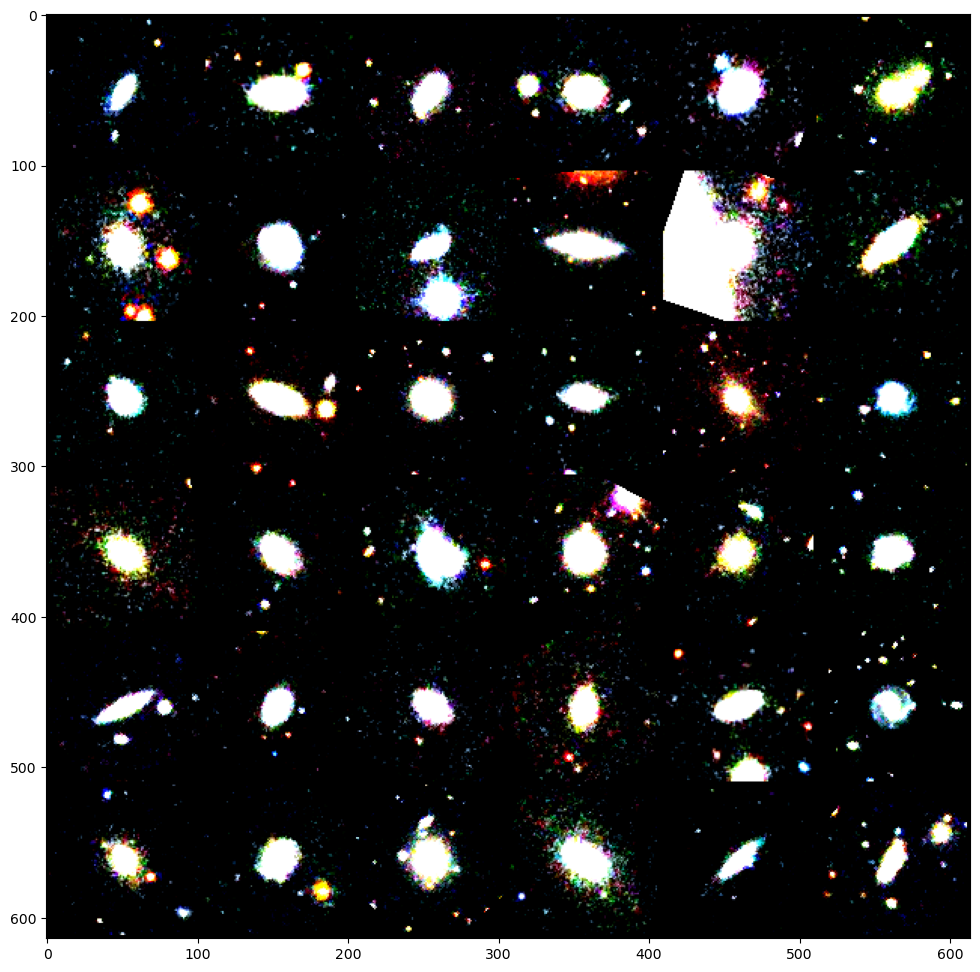

In [42]:
def show_transformed_images(dataset):
    Loader = torch.utils.data.DataLoader(dataset,
                                         batch_size = 36,
                                         shuffle    = True)
    batch = next(iter(Loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images,
                                       nrow = 6)
    
    plt.figure(figsize = (12,12))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels', labels)
    
show_transformed_images(train_dataset)

Section 3 : Creating Neural Network

In [43]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [44]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [45]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = torch.device('cuda')

    for epoch in range(n_epochs):
        print("Epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0
        running_correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()
            
            optimizer.step

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * running_correct / total

        print("  -Training dataset. Got %d out of d% images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))

    evaluate_model_on_test_set(model, test_loader)

    print("Finished")
    return model


In [46]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = torch.device('cuda')

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

        epoch_acc = 100 * predicted_correctly_on_epoch / total
        print("  - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
              % (predicted_correctly_on_epoch, total, epoch))
        

In [47]:

resnet18_model    = models.resnet18(weights = None)

num_ftrs          = resnet18_model.fc.in_features

number_of_classes = 3

resnet18_model.fc = nn.Linear(num_ftrs,
                              number_of_classes)

resnet_18_model   = resnet18_model.to('cuda')

loss_fn           = nn.CrossEntropyLoss()

optimizer         = optim.SGD(resnet18_model.parameters(),
                      lr           = .01,
                      momentum     = 0.9,
                      weight_decay = .003)
                      

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [28]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 5)

Epoch number 1


KeyboardInterrupt: 